# Setup

In [1]:
!python -c 'import matplotlib' || pip install -q matplotlib
!python -c 'import monai' || pip install -q monai
!python -c 'import nibabel' || pip install -q nibabel
!python -c 'import skimage' || pip install -q scikit-image
!python -c 'import ray' || pip install -q ray
!python -c 'import pandas' || pip install -q pandas
!python -c 'import tensorboardX' || pip install -q tensorboardX
!python -c 'import sklearn' || pip install -q scikit-learn
!python -c 'import torchmetrics' || pip install -q torchmetrics
!python -c 'import torchinfo' || pip install -q torchinfo

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'matplotlib'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'nibabel'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'skimage'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'ray'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pandas'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorboardX'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'sklearn'
Traceback (most recent call las

# Imports

In [2]:
import os
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import nibabel as nib
import skimage.transform as skTrans
import time
import pandas
import tensorboardX
import logging

from torchinfo import summary
from torchmetrics import MeanSquaredError, MeanAbsolutePercentageError
from functools import partial
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from monai.data import decollate_batch
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
#    Compose,
#    LoadImage,
#    RandFlip,
#    RandRotate,
#    RandZoom,
#    ScaleIntensity,
)
from monai.utils import set_determinism

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set paths & Initiate Logger

In [3]:
data_dir = os.path.abspath('NIfTI-files/images_structural')
checkpoint_dir = os.path.abspath('NIfTI-files/checkpoints')
model_path = os.path.abspath('NIfTI-files/model.pth')
print('{}\n{}\n{}\n'.format(data_dir, checkpoint_dir, model_path))

#logging.basicConfig(format='%(levelname)s:%(message)s')

# create logger
log = logging.getLogger('model_logger')
log.propagate = False

if not log.handlers:
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(levelname)s: %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    log.addHandler(ch)

/home/jovyan/NIfTI-files/images_structural
/home/jovyan/NIfTI-files/checkpoints
/home/jovyan/NIfTI-files/model.pth



# Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

# Prepare Images

## Save Images

In [5]:
def save_images():
    for patient in tqdm(os.listdir(data_dir)):
        # Get Image paths
        patient_path = os.path.join(data_dir, patient)
        t1_path = os.path.join(patient_path, patient + '_T1.nii.gz')
        t1gd_path = os.path.join(patient_path, patient + '_T1GD.nii.gz')
        t2_path = os.path.join(patient_path, patient + '_T2.nii.gz')
        flair_path = os.path.join(patient_path, patient + '_FLAIR.nii.gz')

        # Load Images
        t1 = nib.load(t1_path).get_fdata()[:,:,77]
        t1gd = nib.load(t1gd_path).get_fdata()[:,:,77]
        t2 = nib.load(t2_path).get_fdata()[:,:,77]
        flair = nib.load(flair_path).get_fdata()[:,:,77]

        # Resize images
        t1 = skTrans.resize(t1, (64,64), order=1, preserve_range=True)
        t1gd = skTrans.resize(t1gd, (64,64), order=1, preserve_range=True)
        t2 = skTrans.resize(t2, (64,64), order=1, preserve_range=True)
        flair = skTrans.resize(flair, (64,64), order=1, preserve_range=True)
        
        # Mask
        t1[t1<1] = 0
        t1gd[t1gd<1] = 0
        t2[t2<1] = 0
        flair[flair<1] = 0
        
        mask = (t1!=0) & (t1gd!=0) & (t2!=0) & (flair!=0)
        
        # Normalize
        mask_flat = mask.copy().flatten()
        t1_flat = t1.copy().flatten()
        t1gd_flat = t1gd.copy().flatten()
        t2_flat = t2.copy().flatten()
        flair_flat = flair.copy().flatten()
        
        t1_mean = np.mean(t1_flat, where=mask_flat)
        t1_std = np.std(t1_flat, where=mask_flat)
        t1gd_mean = np.mean(t1gd_flat, where=mask_flat)
        t1gd_std = np.std(t1gd_flat, where=mask_flat)
        t2_mean = np.mean(t2_flat, where=mask_flat)
        t2_std = np.std(t2_flat, where=mask_flat)
        flair_mean = np.mean(flair_flat, where=mask_flat)
        flair_std = np.std(flair_flat, where=mask_flat)
        
        t1_norm = ((t1 - t1_mean) / (3 * t1_std) + 0.5) * mask
        t1gd_norm = ((t1gd - t1gd_mean) / (3 * t1gd_std) + 0.5) * mask
        t2_norm = ((t2 - t2_mean) / (3 * t2_std) + 0.5) * mask
        flair_norm = ((flair - flair_mean) / (3 * flair_std) + 0.5) * mask
        
        t1_norm[t1_norm<0] = 0
        t1_norm[t1_norm>1] = 1
        t1gd_norm[t1gd_norm<0] = 0
        t1gd_norm[t1gd_norm>1] = 1
        t2_norm[t2_norm<0] = 0
        t2_norm[t2_norm>1] = 1
        flair_norm[flair_norm<0] = 0
        flair_norm[flair_norm>1] = 1

        # Remove Images
        os.remove(os.path.join(patient_path, patient + '_T1_resized.npy')) 
        os.remove(os.path.join(patient_path, patient + '_T1GD_resized.npy'))
        os.remove(os.path.join(patient_path, patient + '_T2_resized.npy'))
        os.remove(os.path.join(patient_path, patient + '_FLAIR_resized.npy'))
        os.remove(os.path.join(patient_path, patient + '_MASK_resized.npy'))

        #Save Images
        np.save(os.path.join(patient_path, patient + '_T1_resized'), t1_norm)
        np.save(os.path.join(patient_path, patient + '_T1GD_resized'), t1gd_norm)
        np.save(os.path.join(patient_path, patient + '_T2_resized'), t2_norm)
        np.save(os.path.join(patient_path, patient + '_FLAIR_resized'), flair_norm)
        np.save(os.path.join(patient_path, patient + '_MASK_resized'), mask)

#save_images()

## Load Images

In [6]:
# All class names
class_names = ['t1', 't1gd', 't2', 'flair', 'mask']

# All Images
image_files = []
image_flairs = []
image_masks = []
patients = []
for patient in tqdm(os.listdir(data_dir)):
    # Get Image paths
    patients.append(patient)
    patient_path = os.path.join(data_dir, patient)
    t1_path = os.path.join(patient_path, patient + '_T1_resized.npy')
    t1gd_path = os.path.join(patient_path, patient + '_T1GD_resized.npy')
    t2_path = os.path.join(patient_path, patient + '_T2_resized.npy')
    flair_path = os.path.join(patient_path, patient + '_FLAIR_resized.npy')
    mask_path = os.path.join(patient_path, patient + '_MASK_resized.npy')
    
    # Load Images
    t1 = np.load(t1_path)
    t1gd = np.load(t1gd_path)
    t2 = np.load(t2_path)
    flair = np.load(flair_path)
    mask = np.load(mask_path)
    
    # Concatenate images
    concat_constrasts = np.zeros((3, 64, 64), dtype=np.float32)
    concat_constrasts[0,:,:] = t1.astype(np.float32)
    concat_constrasts[1,:,:] = t1gd.astype(np.float32)
    concat_constrasts[2,:,:] = t2.astype(np.float32)
    image_files.append(concat_constrasts)
    
    flair_channel = np.zeros((1, 64, 64), dtype=np.float32)
    flair_channel[0] = flair.astype(np.float32)
    image_flairs.append(flair_channel)
    
    mask_channel = np.zeros((1, 64, 64), dtype=np.float32)
    mask_channel[0] = mask.astype(np.float32)
    image_masks.append(mask_channel)

# Number of images
num_total = len(image_files)
    
print(f'Total image count: {num_total}')
#print(image_files[0].dtype, image_files[0][0].dtype)
#print(image_flairs[0].shape)

100%|██████████| 671/671 [00:01<00:00, 593.64it/s]

Total image count: 671


# Randomly pick images from the dataset to visualize and check

UPENN-GBM-00519_11
UPENN-GBM-00589_11
UPENN-GBM-00171_11


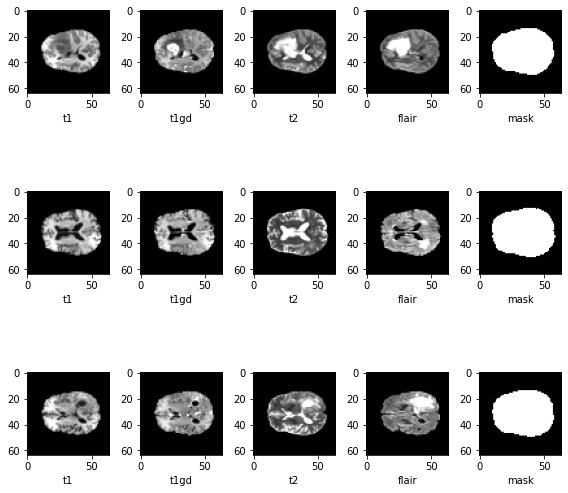

In [7]:
plt.subplots(3, 5, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=3)):
    #print(i, k)
    print(patients[k])
    arr = image_files[k]
    plt.subplot(3, 5, (i * 5) + 1)
    plt.xlabel(class_names[0])
    plt.imshow(arr[0,:,:], cmap='gray')
    plt.subplot(3, 5, (i * 5) + 2)
    plt.xlabel(class_names[1])
    plt.imshow(arr[1,:,:], cmap='gray')
    plt.subplot(3, 5, (i * 5) + 3)
    plt.xlabel(class_names[2])
    plt.imshow(arr[2,:,:], cmap='gray')
    plt.subplot(3, 5, (i * 5) + 4)
    plt.xlabel(class_names[3])
    plt.imshow(image_flairs[k][0,:,:], cmap='gray')
    plt.subplot(3, 5, (i * 5) + 5)
    plt.xlabel(class_names[4])
    plt.imshow(image_masks[k][0,:,:], cmap='gray')
plt.tight_layout()
plt.show()

# Prepare training, validation and test data lists

In [8]:
val_frac = 0.15
test_frac = 0.15
indices = np.arange(num_total)
np.random.shuffle(indices)

test_split = int(test_frac * num_total)
val_split = int(val_frac * num_total) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files[i] for i in train_indices]
train_y = [image_flairs[i] for i in train_indices]
train_mask = [image_masks[i] for i in train_indices]
val_x = [image_files[i] for i in val_indices]
val_y = [image_flairs[i] for i in val_indices]
val_mask = [image_masks[i] for i in val_indices]
test_x = [image_files[i] for i in test_indices]
test_y = [image_flairs[i] for i in test_indices]
test_mask = [image_masks[i] for i in test_indices]

print(f'Training count: {len(train_x)}, Validation count: ' f'{len(val_x)}, Test count: {len(test_x)}')

Training count: 471, Validation count: 100, Test count: 100


# MONAI

## Define transforms

In [9]:
train_transforms = transforms.Compose([
    #EnsureChannelFirst(channel_dim=3),
    #transforms.ToTensor(),
    #transforms.RandomAffine(degrees=[-15, 15], scale=[0.9, 1.1]),
    #transforms.Normalize(0.5, 0.2)
])

val_transforms = transforms.Compose([])

## Define Dataset and Dataloader

In [10]:
class NIfTIDataset(Dataset):
    def __init__(self, input_contrats, flair_contrasts, masks, transforms):
        self.input_contrats = input_contrats
        self.flair_contrasts = flair_contrasts
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.input_contrats)

    def __getitem__(self, index):
        return self.transforms(self.input_contrats[index]), self.flair_contrasts[index], self.masks[index]

train_ds = NIfTIDataset(train_x, train_y, train_mask, train_transforms)

val_ds = NIfTIDataset(val_x, val_y, val_mask, val_transforms)

test_ds = NIfTIDataset(test_x, test_y, test_mask, val_transforms)
#test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

# U-Net Generator

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [12]:
model = UNET(in_channels=3, out_channels=1, features=[64, 128, 256, 512])
print(summary(model, input_size=(10, 3, 64, 64)))
print(model)

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [10, 1, 64, 64]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [10, 64, 64, 64]          --
│    │    └─Sequential: 3-1              [10, 64, 64, 64]          38,848
├─MaxPool2d: 1-2                         [10, 64, 32, 32]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [10, 128, 32, 32]         --
│    │    └─Sequential: 3-2              [10, 128, 32, 32]         221,696
├─MaxPool2d: 1-4                         [10, 128, 16, 16]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [10, 256, 16, 16]         --
│    │    └─Sequential: 3-3              [10, 256, 16, 16]         885,760
├─MaxPool2d: 1-6                         [10

# Train & Validation

## Train function

In [13]:
def train_model(config, train_ds, val_ds, checkpoint_dir=None, log_level=logging.WARNING):
    batch_size = config['batch_size']
    epochs = config['epochs']
    device = config['device']
    log.setLevel(log_level)

    model = UNET(in_channels=3, out_channels=1, features=config['features']).to(device)
    
    # Early stopping
    last_loss = 100
    patience = 5
    trigger_times = 0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    loss_function = config['loss']
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()
    mape_loss = MeanAbsolutePercentageError().to(device)
    rmse_loss = MeanSquaredError(squared=False).to(device)
    
    train_loss_per_batch = []
    global train_loss 
    train_loss = []
    val_loss_per_batch = []
    global val_loss 
    val_loss = []
    
    #if checkpoint_dir:
        #model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, 'checkpoint'))
        #model.load_state_dict(model_state)
        #optimizer.load_state_dict(optimizer_state)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=10)

    for epoch in range(1, epochs + 1):
        # Training
        if log_level <= logging.INFO:
            log.info('-'*50)
            log.info('Training')
            log.info('-'*50)
            log.info('Train Epoch: %d/%d', epoch, epochs)
        
        model.train()
        batches_trained = 0
        running_loss = 0.0
        mse_sum = 0
        mae_sum = 0
        mape_sum = 0
        rmse_sum = 0
        
        for times, (inputs, labels, masks) in enumerate(train_loader, 1):
            (inputs, labels, masks) = (inputs.to(device), labels.to(device), masks.to(device))
            batches_trained += len(inputs)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation            
            output = model(inputs)
            output *= masks
            
            loss = loss_function(output, labels)
            running_loss += loss.item()
            train_loss_per_batch.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            mse = mse_loss(output, labels)
            mse_sum += mse
            mae = mae_loss(output, labels)
            mae_sum += mae
            mape = mape_loss(output, labels)
            mape_sum += mape
            rmse = rmse_loss(output, labels)
            rmse_sum += rmse
                
            # Show progress
            log.debug('Train Epoch: %d/%d [%d/%d (%.0f%%)]\tLoss: %.3f\tMSE: %.3f\tMAE: %.3f\tMAPE: %.3f\tRMSE: %.3f',
                epoch, epochs, batches_trained, len(train_loader.dataset), 
                100. * (times) / len(train_loader), loss.item(), mse, mae, mape, rmse)

        train_loss.append(running_loss / times)
        log.debug('Average loss: %.3f\tAverage MSE: %.3f\tAverage MAE: %.3f\tAverage MAPE: %.3f\tAverage RMSE: %.3f'
                 , running_loss / times, mse_sum / times, mae_sum / times, mape_sum / times, rmse_sum / times)
        
        if log_level <= logging.INFO:
            img_label = labels[-1].cpu()
            img_output = output[-1].cpu().detach().numpy()
            img_input = inputs[-1].cpu()
            img_mask = masks[-1].cpu()

            log.info('Training Image')
            show_img(img_input, img_label, img_mask, img_output)
        
        # Validation
        if log_level <= logging.INFO:
            log.info('-'*50)
            log.info('Validation')
            log.info('-'*50)
            log.info('Train Epoch: %d/%d', epoch, epochs)
        
        model.eval()
        running_loss = 0.0
        mse_sum = 0
        mae_sum = 0
        mape_sum = 0
        rmse_sum = 0

        with torch.no_grad():
            for times, (inputs, labels, masks) in enumerate(val_loader, 1):
                (inputs, labels, masks) = (inputs.to(device), labels.to(device), masks.to(device))

                output = model(inputs)
                output *= masks
                loss = loss_function(output, labels)
                running_loss += loss.item()
                val_loss_per_batch.append(loss.item())
                
                mse = mse_loss(output, labels)
                mse_sum += mse
                mae = mae_loss(output, labels)
                mae_sum += mae
                mape = mape_loss(output, labels)
                mape_sum += mape
                rmse = rmse_loss(output, labels)
                rmse_sum += rmse
                log.debug('MSE: %.3f\tMAE: %.3f\tMAPE: %.3f\tRMSE: %.3f', mse, mae, mape, rmse)

            val_loss.append(running_loss / times)
            log.debug('Average loss: %.3f\tAverage MSE: %.3f\tAverage MAE: %.3f\tAverage MAPE: %.3f\tAverage RMSE: %.3f'
                     , running_loss / times, mse_sum / times, mae_sum / times, mape_sum / times, rmse_sum / times)

            if log_level <= logging.INFO:
                img_label = labels[-1].cpu()
                img_output = output[-1].cpu().detach().numpy()
                img_input = inputs[-1].cpu()
                img_mask = masks[-1].cpu()

                log.info('Validation Image')
                show_img(img_input, img_label, img_mask, img_output)
        
        #with tune.checkpoint_dir(epoch) as checkpoint_dir:
            #path = os.path.join(checkpoint_dir, 'checkpoint')
            #torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(running_loss / times))

        # Early stopping
        current_loss = running_loss / times
        log.debug('The Current Loss: %.3f', current_loss)

        if current_loss >= last_loss:
            trigger_times += 1
            log.debug('Trigger Times: %d', trigger_times)

            if trigger_times >= patience:
                log.debug('Early stopping!\nStart to test process.')
                return

        else:
            log.debug('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss

    #return model

def show_img(inputs, labels, masks, outputs):
    plt.style.use('dark_background')
    plt.subplots(1, 6, figsize=(16, 16))
    
    # T1
    plt.subplot(1, 6, 1)
    plt.xlabel('T1')
    plt.imshow(inputs[0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # T1GD
    plt.subplot(1, 6, 2)
    plt.xlabel('T1GD')
    plt.imshow(inputs[1], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # T2
    plt.subplot(1, 6, 3)
    plt.xlabel('T2')
    plt.imshow(inputs[2], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Real Flair
    plt.subplot(1, 6, 4)
    plt.xlabel('Real Flair')
    plt.imshow(labels[0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Generated Flair
    plt.subplot(1, 6, 5)
    plt.xlabel('Generated Flair')
    plt.imshow(outputs[0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Mask
    plt.subplot(1, 6, 6)
    plt.xlabel('Mask')
    plt.imshow(masks[0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    plt.tight_layout()
    plt.show()

## Train the model

INFO: --------------------------------------------------
INFO: Training
INFO: --------------------------------------------------
INFO: Train Epoch: 1/5
INFO: Training Image


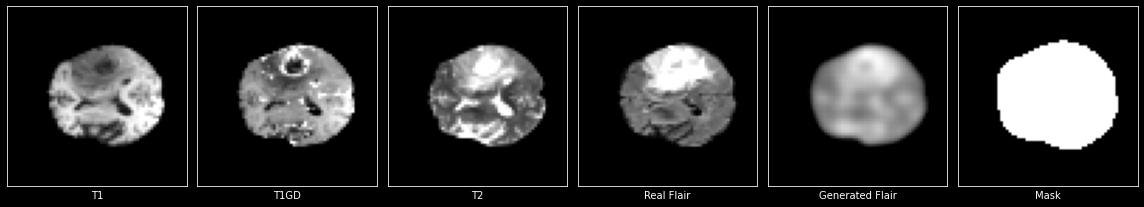

INFO: --------------------------------------------------
INFO: Validation
INFO: --------------------------------------------------
INFO: Train Epoch: 1/5
INFO: Validation Image


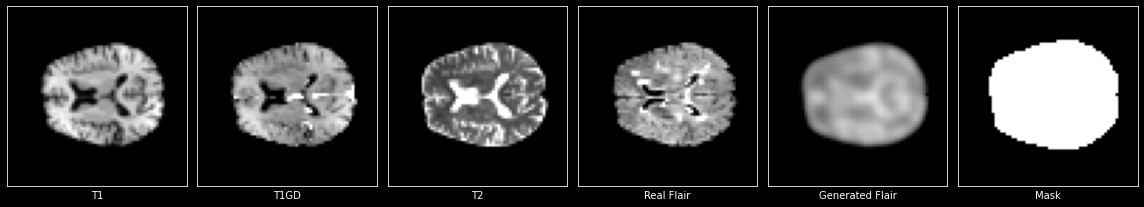

2023-04-26 10:01:56,495 - Session not detected. You should not be calling `report` outside `tuner.fit()` or while using the class API. 
2023-04-26 10:01:56,496 -   File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
    self._run_once()
  File "/opt/

INFO: --------------------------------------------------
INFO: Training
INFO: --------------------------------------------------
INFO: Train Epoch: 2/5
INFO: Training Image


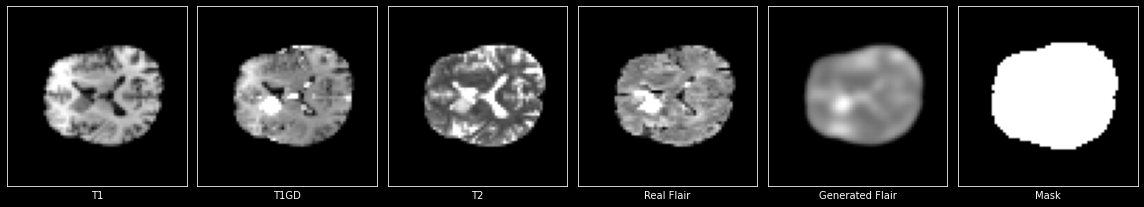

INFO: --------------------------------------------------
INFO: Validation
INFO: --------------------------------------------------
INFO: Train Epoch: 2/5
INFO: Validation Image


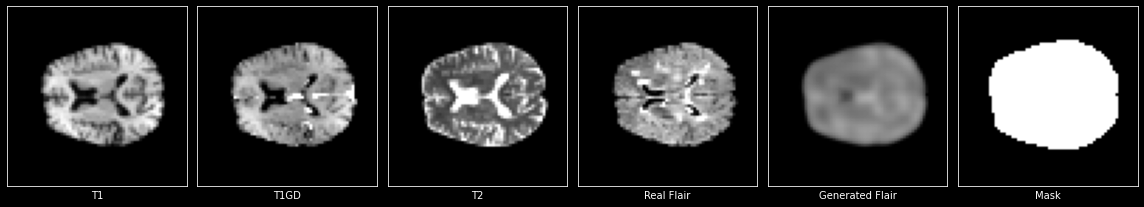

INFO: --------------------------------------------------
INFO: Training
INFO: --------------------------------------------------
INFO: Train Epoch: 3/5
INFO: Training Image


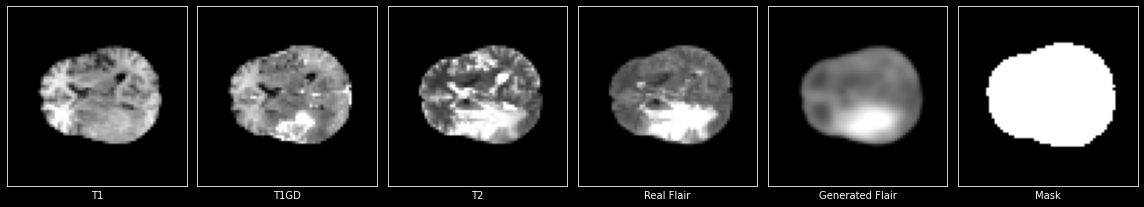

INFO: --------------------------------------------------
INFO: Validation
INFO: --------------------------------------------------
INFO: Train Epoch: 3/5
INFO: Validation Image


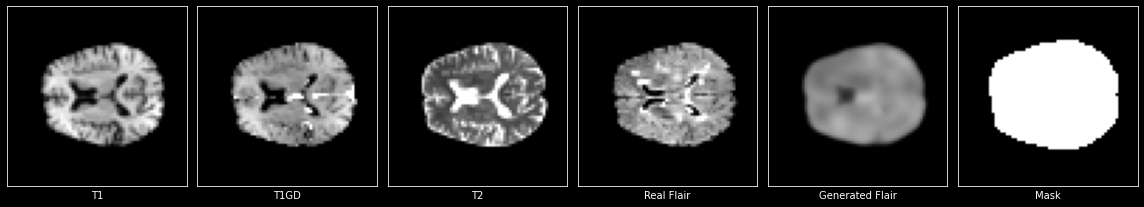

INFO: --------------------------------------------------
INFO: Training
INFO: --------------------------------------------------
INFO: Train Epoch: 4/5
INFO: Training Image


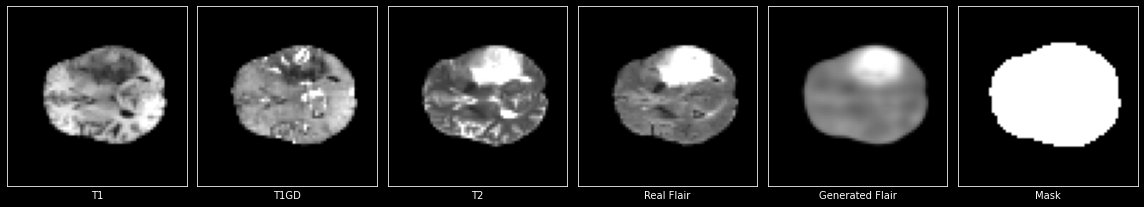

INFO: --------------------------------------------------
INFO: Validation
INFO: --------------------------------------------------
INFO: Train Epoch: 4/5
INFO: Validation Image


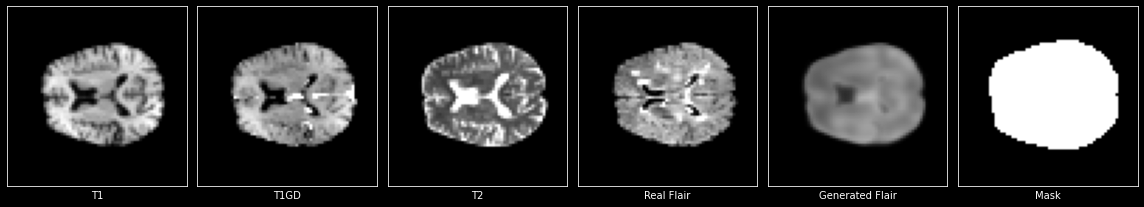

INFO: --------------------------------------------------
INFO: Training
INFO: --------------------------------------------------
INFO: Train Epoch: 5/5
INFO: Training Image


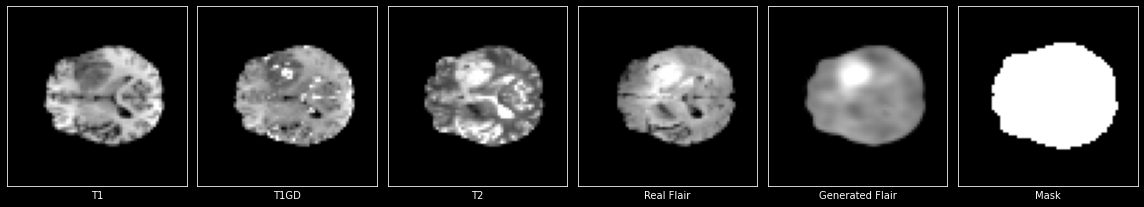

INFO: --------------------------------------------------
INFO: Validation
INFO: --------------------------------------------------
INFO: Train Epoch: 5/5
INFO: Validation Image


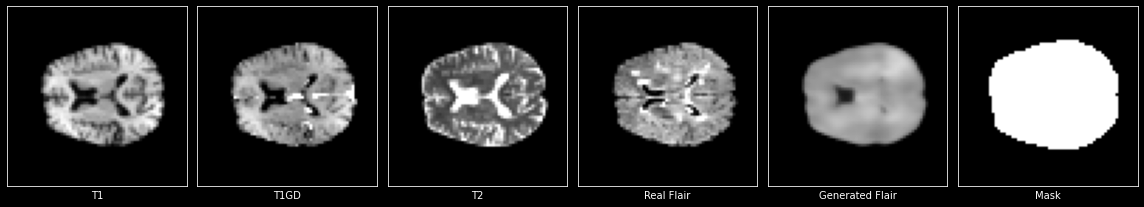

In [14]:
config = {
    'lr': 1e-2,
    'batch_size': 10,
    'loss': nn.L1Loss(),
    'features': [64, 128, 256, 512],
    'epochs': 5,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

train_model(config, train_ds, val_ds, log_level=logging.INFO)

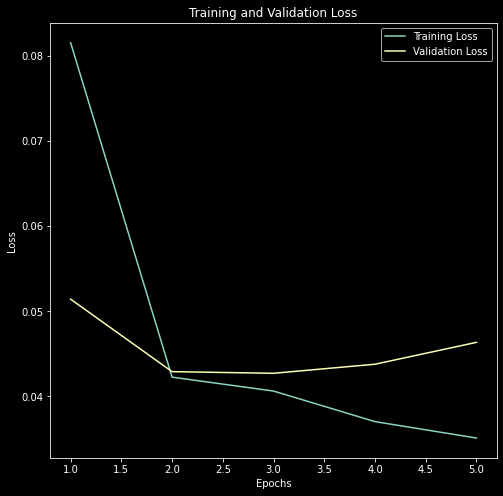

Train: ['0.08157', '0.04225', '0.04062', '0.03702', '0.03509']
Val: ['0.05142', '0.04290', '0.04271', '0.04377', '0.04634']


In [15]:
epochs = range(1, config['epochs']+1)

plt.style.use('dark_background')
plt.subplots(1, 1, figsize=(8, 8))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend(loc='best')
plt.show()

print('Train: {}\nVal: {}'.format(['%.5f' % elem for elem in train_loss], ['%.5f' % elem for elem in val_loss]))

In [16]:
def main(num_trials=10, num_epochs=10, cpus_per_trial=1, gpus_per_trial=1):

    config = {
        'lr': tune.loguniform(1e-5, 1e-2),
        'batch_size': tune.choice([5, 10, 25, 50]),
        'loss': tune.choice([nn.L1Loss(), nn.MSELoss(), nn.KLDivLoss(), nn.HingeEmbeddingLoss(),
                             nn.HuberLoss(), nn.SmoothL1Loss(), nn.BCEWithLogitsLoss()]),
        'features': tune.choice([[32, 64, 128, 256], [64, 128, 256, 512], [128, 256, 512, 1024]]),
        'epochs': num_epochs,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    }

    scheduler = ASHAScheduler(
        metric='loss',
        mode='min',
        max_t=config['epochs']
    )

    reporter = CLIReporter(
        metric_columns=['loss', 'accuracy', 'training_iteration']
    )

    result = tune.run(
        partial(train_model, train_ds=train_ds, val_ds=val_ds, checkpoint_dir=None),
        resources_per_trial={'cpu': cpus_per_trial, 'gpu': gpus_per_trial},
        config=config,
        num_samples=num_trials,
        scheduler=scheduler,
        progress_reporter=reporter
    )
    
    best_trial = result.get_best_trial('loss', 'min', 'last')
    print('Best trial config: {}'.format(best_trial.config))
    print('Best trial final validation loss: {}'.format(best_trial.last_result['loss']))
    print('Best trial final validation accuracy: {}'.format(best_trial.last_result['accuracy']))

In [17]:
#main(15, 100, 7, 1)